# Implicit neural networks

This notebook is exctracted from the tutorial [Deep Implicit Layers](http://implicit-layers-tutorial.org) chapters 1 and 4. It covers the basic principles of implicit layers and a Deep Equilibrium Model (DEQ) architecture. The first part covers the implementation of implicit layers and how to link it with Pytorch's backpropagation. The second part covers DEQs.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.autograd as autograd

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.autograd import gradcheck
from epoch import epoch, epoch_cifar

In [2]:
# from utils import set_seed
torch.cuda.empty_cache()

device = 'cuda:0'
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3090


### Fixed point iteration

As a first example we consider the following fixed point iteration:

$$
    z_{k+1} = \tanh{(Wz_k + b)}
$$

In [3]:
class TanhFixedPointLayer(nn.Module):
    def __init__(self, out_features, tol = 1e-4, max_iter=50):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter
  
    def forward(self, x):
        # initialize output z to be zero
        z = torch.zeros_like(x)
        self.iterations = 0

        # iterate until convergence
        while self.iterations < self.max_iter:
            z_next = torch.tanh(self.linear(z) + x)
            self.err = torch.norm(z - z_next)
            z = z_next
            self.iterations += 1
            if self.err < self.tol:
                break

        return z

Let's run the fixed point iteration

In [4]:
layer = TanhFixedPointLayer(50)
X = torch.randn(10,50)
Z = layer(X)
print(f"Terminated after {layer.iterations} iterations with error {layer.err}")

Terminated after 15 iterations with error 9.591078560333699e-05


Let's train this simple network on the MNIST dataset to see how well it performs.

In [5]:
mnist_train = datasets.MNIST(".", train=True, download=False, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(".", train=False, download=False, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

Below we add a first and final layer to make sure the dimensions of the input and output are matched. Note that the fixed point layer has a width of 100.

In [6]:
torch.manual_seed(0)
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(784, 100),
                      TanhFixedPointLayer(100, max_iter=200),
                      nn.Linear(100, 10)
                      ).to(device)
opt = optim.SGD(model.parameters(), lr=1e-1)

In [7]:
for i in range(10):
    if i == 5:
        opt.param_groups[0]["lr"] = 1e-2

    train_err, train_loss, train_fpiter = epoch(train_loader, model, opt, lambda x : x[2].iterations)
    test_err, test_loss, test_fpiter = epoch(test_loader, model, monitor = lambda x : x[2].iterations)
    print(f"Train Error: {train_err:.4f}, Loss: {train_loss:.4f}, FP Iters: {train_fpiter:.2f} | " +
          f"Test Error: {test_err:.4f}, Loss: {test_loss:.4f}, FP Iters: {test_fpiter:.2f}")

  0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: 

Although this simple fixed point iteration works there exist faster root finding methods, like Newton's iteration:

$$
    z_{k+1} = z_k - \left(\frac{\partial g}{\partial z}\right)^{-1}g(z_k).
$$

The Jacobian is given by

$$
    \frac{\partial g}{\partial z} = I - \text{diag}\left(\tanh^{'}(Wz+x)\right)
$$

We implement this method below

In [56]:
class TanhNewtonLayer(nn.Module):
    def __init__(self, out_features, tol = 1e-4, max_iter=100):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter
  
    def forward(self, x):
        # initialize output z to be zero
        z = torch.tanh(x)
        self.iterations = 0
    
        # iterate until convergence
        while self.iterations < self.max_iter:
            z_linear = self.linear(z) + x
            g = z - torch.tanh(z_linear)
            self.err = torch.norm(g)
            if self.err < self.tol:
                break
            
#             print((1 / torch.cosh(z_linear)**2)[:,:,None]*self.linear.weight[None,:,:].is_cuda)
            # newton step
            J = torch.eye(z.shape[1])[None,:,:].to(z.device) - (1 / torch.cosh(z_linear)**2)[:,:,None]*self.linear.weight[None,:,:]
            z = z - torch.linalg.solve(J, g)
            self.iterations += 1

        g = z - torch.tanh(self.linear(z) + x)
        z[torch.norm(g,dim=1) > self.tol,:] = 0
        return z


In [57]:
layer = TanhNewtonLayer(50)
X = torch.randn(10,50)
Z = layer(X)
print(f"Terminated after {layer.iterations} iterations with error {layer.err}")

Terminated after 3 iterations with error 1.189932731904264e-06


In [58]:
torch.manual_seed(0)
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(784, 100),
                      TanhNewtonLayer(100, max_iter=40),
                      nn.Linear(100, 10)
                      ).to(device)
opt = optim.SGD(model.parameters(), lr=1e-1)

for i in range(8):
    if i == 5:
        opt.param_groups[0]["lr"] = 1e-2

    train_err, train_loss, train_fpiter = epoch(train_loader, model, opt, lambda x : x[2].iterations)
    test_err, test_loss, test_fpiter = epoch(test_loader, model, monitor = lambda x : x[2].iterations)
    print(f"Train Error: {train_err:.4f}, Loss: {train_loss:.4f}, Newton Iters: {train_fpiter:.2f} | " +
          f"Test Error: {test_err:.4f}, Loss: {test_loss:.4f}, Newton Iters: {test_fpiter:.2f}")


  0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Implicit layers

Let's now look at how to implement this layer implicitly. We're solving for the root of the equation

$$
    g(x, z) := z - \tanh{(Wz + b)} = 0,
$$

and denote by $z_{\star}(x)$ the $z$ that satisfies

$$
    g(x, z_{\star}(x)) = 0.
$$

Differentiating this equation on both sides with respect to $x$ yields

$$
    \frac{\partial g(x, z_{\star}(x))}{\partial x} = \frac{\partial g(x, z_{\star})}{\partial x} + \frac{\partial g(x, z_{\star})}{\partial z_{\star}}\frac{\partial z_{\star}}{\partial x} = 0
$$

Solving for $\frac{\partial z_{\star}}{\partial x}$ yields

$$
    \frac{\partial z_{\star}}{\partial x} = -\left(\frac{\partial g(x, z_{\star})}{\partial z_{\star}}\right)^{-1}\frac{\partial g(x, z_{\star})}{\partial x}
$$

When updating the model we consider some loss function with respect to which we want to differentiate. Denoting the loss function by $l$, we actually compute

$$
    \frac{\partial l}{\partial x} = \frac{\partial l}{\partial z_{\star}}\frac{\partial z_{\star}}{\partial x} = -\frac{\partial l}{\partial z_{\star}}\left(\frac{\partial g(x, z_{\star})}{\partial z_{\star}}\right)^{-1}\frac{\partial g(x, z_{\star})}{\partial x}
$$

Automatic differentiation typically works on the gradient instead of the Jacobian, and for a scalar valued function the gradient is just the transpose of the Jacobian, i.e.

$$
    \nabla_{z_{\star}} l = \left(\frac{\partial l}{\partial z_{\star}}\right)^T.
$$

Hence

$$
    \nabla_x l = -\left(\frac{\partial g(x, z_{\star})}{\partial x}\right)^T\left(\frac{\partial g(x, z_{\star})}{\partial z_{\star}}\right)^{-T}\nabla_{z_{\star}}l
$$

It's important to realize that the function that is implemented is not standard. The function first finds a fixed point that is not needed within the automatic differentiation, and then a backward pass that acts accordingly. To implement this function we take the following steps:

1. Solve $(g(x, z_{\star})) = 0$. This part of the forward is *outside* of the automatic differentiation.

2. Activate the automatic differentiation using the following assignment:

$$
    z := z_{\star} - g(x, z_{\star}).
$$

3. Multiply by $\left(\frac{\partial g}{\partial z_{\star}}\right)^{-T}$ so the backward pass correctly implements the gradient according to the implicit function theorem.

In [59]:
class TanhNewtonImplicitLayer(nn.Module):
    def __init__(self, out_features, tol = 1e-4, max_iter=50):
        super().__init__()
        self.linear = nn.Linear(out_features, out_features, bias=False)
        self.tol = tol
        self.max_iter = max_iter
  
    def forward(self, x):
        # Run Newton's method outside of the autograd framework
        with torch.no_grad():
            z = torch.tanh(x)
            self.iterations = 0
            while self.iterations < self.max_iter:
                z_linear = self.linear(z) + x
                g = z - torch.tanh(z_linear)
                self.err = torch.norm(g)
                if self.err < self.tol:
                    break

                # newton step
                J = torch.eye(z.shape[1])[None,:,:].to(z.device) - (1 / torch.cosh(z_linear)**2)[:,:,None]*self.linear.weight[None,:,:]
                z = z - torch.linalg.solve(J, g)
                self.iterations += 1
    
        # reengage autograd and add the gradient hook
        z = torch.tanh(self.linear(z) + x)
        z.register_hook(lambda grad : torch.linalg.solve(J.transpose(1,2), grad))
        return z


In [60]:
layer = TanhNewtonImplicitLayer(5, tol=1e-10).double()
gradcheck(layer, torch.randn(3, 5, requires_grad=True, dtype=torch.double), check_undefined_grad=False)

True

In [61]:
torch.manual_seed(0)
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(784, 100),
                      TanhNewtonImplicitLayer(100, max_iter=40),
                      nn.Linear(100, 10)
                      ).to(device)
opt = optim.SGD(model.parameters(), lr=1e-1)

for i in range(10):
    if i == 5:
        opt.param_groups[0]["lr"] = 1e-2

    train_err, train_loss, train_fpiter = epoch(train_loader, model, opt, lambda x : x[2].iterations)
    test_err, test_loss, test_fpiter = epoch(test_loader, model, monitor = lambda x : x[2].iterations)
    print(f"Train Error: {train_err:.4f}, Loss: {train_loss:.4f}, Newton Iters: {train_fpiter:.2f} | " +
          f"Test Error: {test_err:.4f}, Loss: {test_loss:.4f}, Newton Iters: {test_fpiter:.2f}")

  0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Deep Equilibrium Models

In [14]:
class ResNetLayer(nn.Module):
    def __init__(self, n_channels, n_inner_channels, kernel_size=3, num_groups=8):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, n_inner_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.conv2 = nn.Conv2d(n_inner_channels, n_channels, kernel_size, padding=kernel_size//2, bias=False)
        self.norm1 = nn.GroupNorm(num_groups, n_inner_channels)
        self.norm2 = nn.GroupNorm(num_groups, n_channels)
        self.norm3 = nn.GroupNorm(num_groups, n_channels)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        
    def forward(self, z, x):
        y = self.norm1(F.relu(self.conv1(z)))
        return self.norm3(F.relu(z + self.norm2(x + self.conv2(y))))


In [15]:
def anderson(f, x0, m=5, lam=1e-4, max_iter=50, tol=1e-2, beta = 1.0):
    """ Anderson acceleration for fixed point iteration. """
    bsz, d, H, W = x0.shape
    X = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    F = torch.zeros(bsz, m, d*H*W, dtype=x0.dtype, device=x0.device)
    X[:,0], F[:,0] = x0.view(bsz, -1), f(x0).view(bsz, -1)
    X[:,1], F[:,1] = F[:,0], f(F[:,0].view_as(x0)).view(bsz, -1)
    
    H = torch.zeros(bsz, m+1, m+1, dtype=x0.dtype, device=x0.device)
    H[:,0,1:] = H[:,1:,0] = 1
    y = torch.zeros(bsz, m+1, 1, dtype=x0.dtype, device=x0.device)
    y[:,0] = 1
    
    res = []
    for k in range(2, max_iter):
        n = min(k, m)
        G = F[:,:n]-X[:,:n]
        H[:,1:n+1,1:n+1] = torch.bmm(G,G.transpose(1,2)) + lam*torch.eye(n, dtype=x0.dtype,device=x0.device)[None]
        alpha = torch.linalg.solve(H[:,:n+1,:n+1], y[:,:n+1])[:, 1:n+1, 0]
        X[:,k%m] = beta * (alpha[:,None] @ F[:,:n])[:,0] + (1-beta)*(alpha[:,None] @ X[:,:n])[:,0]
        F[:,k%m] = f(X[:,k%m].view_as(x0)).view(bsz, -1)
        res.append((F[:,k%m] - X[:,k%m]).norm().item()/(1e-5 + F[:,k%m].norm().item()))
        if (res[-1] < tol):
            break
    return X[:,k%m].view_as(x0), res


Text(0, 0.5, 'Relative residual')

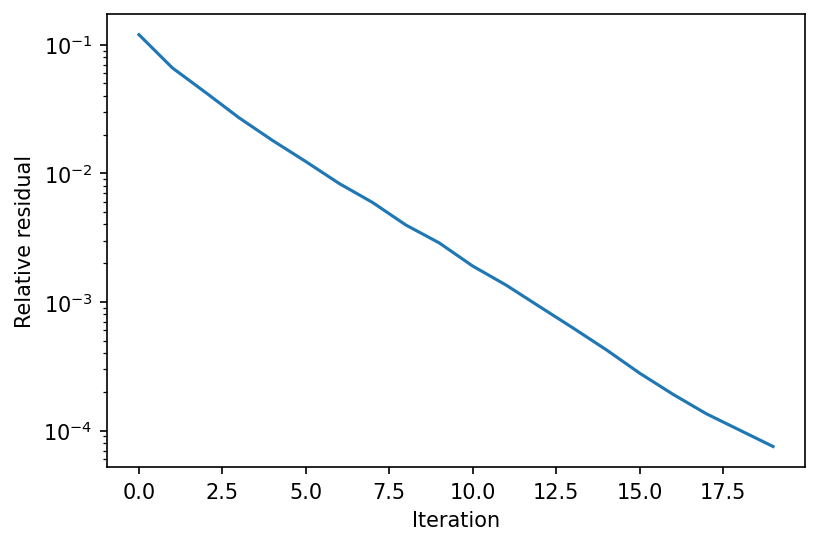

In [16]:
X = torch.randn(10,64,32,32)
f = ResNetLayer(64,128)
Z, res = anderson(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4, beta=1.0)
plt.figure(dpi=150)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")

Text(0, 0.5, 'Relative residual')

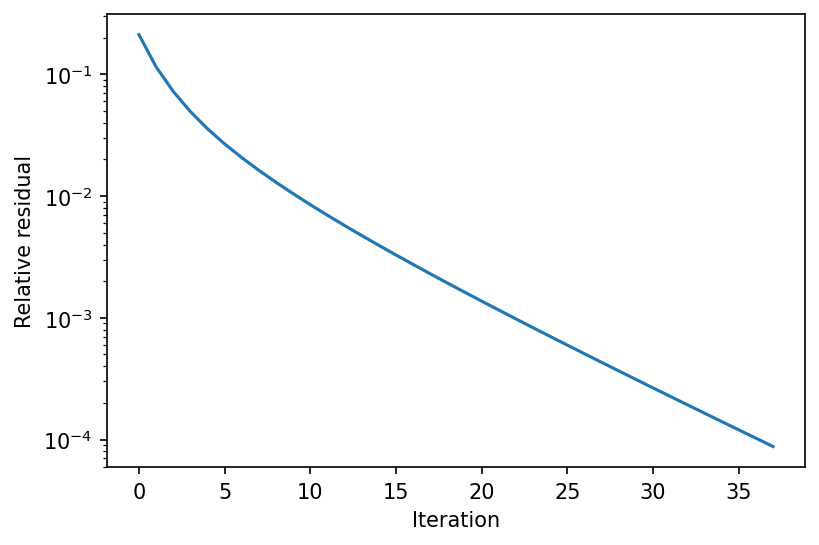

In [17]:
def forward_iteration(f, x0, max_iter=50, tol=1e-2):
    f0 = f(x0)
    res = []
    for k in range(max_iter):
        x = f0
        f0 = f(x)
        res.append((f0 - x).norm().item() / (1e-5 + f0.norm().item()))
        if (res[-1] < tol):
            break
    return f0, res

Z, res = forward_iteration(lambda Z : f(Z,X), torch.zeros_like(X), tol=1e-4)
plt.figure(dpi=150)
plt.semilogy(res)
plt.xlabel("Iteration")
plt.ylabel("Relative residual")


In [18]:
class DEQFixedPoint(nn.Module):
    def __init__(self, f, solver, **kwargs):
        super().__init__()
        self.f = f
        self.solver = solver
        self.kwargs = kwargs
        
    def forward(self, x):
        # compute forward pass and re-engage autograd tape
        with torch.no_grad():
            z, self.forward_res = self.solver(lambda z : self.f(z, x), torch.zeros_like(x), **self.kwargs)
        z = self.f(z,x)
        
        # set up Jacobian vector product (without additional forward calls)
        z0 = z.clone().detach().requires_grad_()
        f0 = self.f(z0,x)
        def backward_hook(grad):
            g, self.backward_res = self.solver(lambda y : autograd.grad(f0, z0, y, retain_graph=True)[0] + grad,
                                               grad, **self.kwargs)
            return g
                
        z.register_hook(backward_hook)
        return z

In [19]:
# run a very small network with double precision, iterating to high precision
f = ResNetLayer(2,2, num_groups=2).double()
deq = DEQFixedPoint(f, anderson, tol=1e-10, max_iter=500).double()
gradcheck(deq, torch.randn(1,2,3,3).double().requires_grad_(), eps=1e-5, atol=1e-3, check_undefined_grad=False)

True

In [20]:
f = ResNetLayer(64,128)
deq = DEQFixedPoint(f, anderson, tol=1e-4, max_iter=100, beta=2.0)
X = torch.randn(10,64,32,32)
out = deq(X)
(out*torch.randn_like(out)).sum().backward()

Text(0, 0.5, 'Residual')

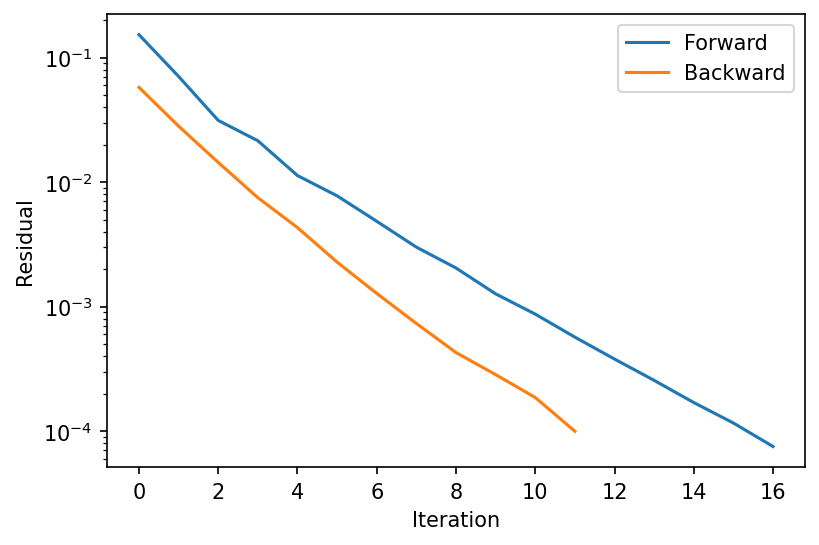

In [21]:
plt.figure(dpi=150)
plt.semilogy(deq.forward_res)
plt.semilogy(deq.backward_res)
plt.legend(['Forward', 'Backward'])
plt.xlabel("Iteration")
plt.ylabel("Residual")

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(0)
chan = 48
f = ResNetLayer(chan, 64, kernel_size=3)
model = nn.Sequential(nn.Conv2d(3,chan, kernel_size=3, bias=True, padding=1),
                      nn.BatchNorm2d(chan),
                      DEQFixedPoint(f, anderson, tol=1e-2, max_iter=25, m=5),
                      nn.BatchNorm2d(chan),
                      nn.AvgPool2d(8,8),
                      nn.Flatten(),
                      nn.Linear(chan*4*4,10)).to(device)

In [ ]:
cifar10_train = datasets.CIFAR10(".", train=True, download=False, transform=transforms.ToTensor())
cifar10_test = datasets.CIFAR10(".", train=False, download=False, transform=transforms.ToTensor())
train_loader = DataLoader(cifar10_train, batch_size = 100, shuffle=True, num_workers=8)
test_loader = DataLoader(cifar10_test, batch_size = 100, shuffle=False, num_workers=8)

In [ ]:
opt = optim.Adam(model.parameters(), lr=1e-3)
print("# Parameters: ", sum(a.numel() for a in model.parameters()))

max_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, max_epochs*len(train_loader), eta_min=1e-6)

for i in range(50):
    print(epoch_cifar(train_loader, model, opt, scheduler))
    print(epoch_cifar(test_loader, model)) 